In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf

In [2]:


# ----------------- Data Loading and Preprocessing ------------------
# Load CSV files
train = pd.read_csv('train.csv')
test = pd.read_csv('sample_submission.csv')
sub = pd.read_csv('sample_submission.csv')

# Define paths
train_path = 'Train/'
test_path = 'Test/'

# Label binary encoding (0 and 1)
cls_to_idx = {'editada': 0, 'real': 1}
train['label'] = [cls_to_idx[x] for x in train['label'].values]

# Convert labels to string format ('0' or '1')
train['label'] = train['label'].astype(str)

# Fixing file paths: Ensure full paths for images
train['image'] = train_path + train['image']
test['image'] = test_path + test['image']

# If needed, append file extension if missing (e.g., .jpg)
train['image'] = train['image'].apply(lambda x: x if x.endswith(('.jpg', '.png')) else x + '.jpg')
test['image'] = test['image'].apply(lambda x: x if x.endswith(('.jpg', '.png')) else x + '.jpg')

# Data splitting
train_df, val_df = train_test_split(train, test_size=0.15, random_state=42, stratify=train['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# ----------------- Data Augmentation ------------------
# Define ImageDataGenerators for training and validation
image_size = (299, 299)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe for training
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Use binary labels (0 or 1)
)

# Flow from dataframe for validation
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Use binary labels (0 or 1)
)

# Test generator for predictions
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col=None,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False  # No shuffle for test set
)

# ----------------- Model Definition ------------------
# Use the Xception model defined earlier
input_shape = (299, 299, 3)
num_classes = 1  # Binary classification: 'editada' or 'real'

# Load pre-trained Xception
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model layers
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# ----------------- Training the Model ------------------
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('xception_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint]
)



Training set size: 612
Validation set size: 108
Found 612 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.
Found 180 validated image filenames.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

C:\Users\Rafid\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.5156 - loss: 0.7927 - val_accuracy: 0.6019 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.5841 - loss: 0.6641 - val_accuracy: 0.6111 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6606 - loss: 0.6384 - val_accuracy: 0.5926 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.6283 - loss: 0.6120 - val_accuracy: 0.6481 - val_loss: 0.6039 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.6523 - loss: 0.6331 - val_accuracy: 0.6481 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.6168 - loss: 0.6486 - val_accuracy: 0.5926 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.6251 - loss: 0.6271 - val_accuracy

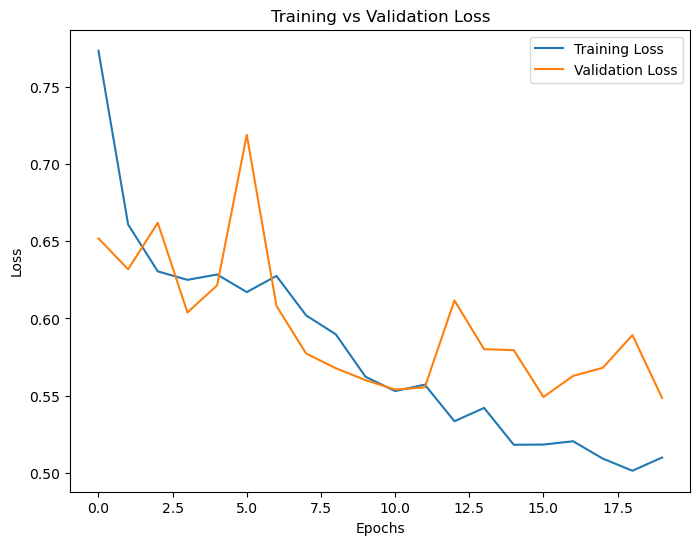

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


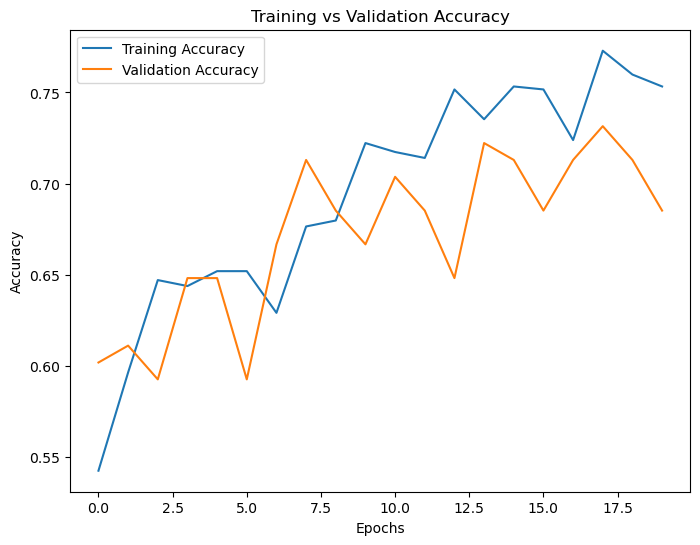

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming that the images should be resized to (299, 299)
image_size = (299, 299)  # Change this to match the model's expected input size
batch_size = 32

# Preprocessing function (normalization or any other transformations)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Set up the test data generator with resized images
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,  # Your test dataframe
    directory=None,   # Set to None if the 'image' column already contains full paths
    x_col='image',    # Column containing image file paths
    y_col='label',    # Column containing labels
    target_size=image_size,  # Resize images to (299, 299)
    batch_size=batch_size,
    class_mode='raw',  # Use 'binary' if it's binary classification
    shuffle=False  # No shuffling for test set
)

# Predict on the test data
predictions = model.predict(test_generator, verbose=1)

# Apply a threshold (e.g., 0.5) to convert probabilities to class labels (for binary classification)
#predicted_labels = (predictions > 0.5).astype(int)


# Create the submission DataFrame
submission_df = pd.DataFrame({'image': sub['image'], 'label': predictions.flatten()})

# Save the submission as a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been saved.")